In [25]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from scipy.optimize import minimize

In [63]:
tickers = [
    # Large Cap (Future-focused and strong fundamentals)
    "RELIANCE.NS", "TCS.NS", "INFY.NS", "HDFCBANK.NS", "ICICIBANK.NS", "HINDUNILVR.NS", "MARUTI.NS", "KOTAKBANK.NS", "BAJFINANCE.NS", "ITC.NS", "BHARTIARTL.NS", "LT.NS", "AXISBANK.NS", "NESTLEIND.NS",
    "ULTRACEMCO.NS", "DIVISLAB.NS", "TITAN.NS", "WIPRO.NS",

    # Mid Cap (Growth and emerging sectors)
    "AARTIIND.NS", "DEEPAKNTR.NS", "CUMMINSIND.NS", "INDIAMART.NS", "POLYCAB.NS", "AUBANK.NS",
    "BALKRISIND.NS", "LALPATHLAB.NS", "ICICIGI.NS", "BERGEPAINT.NS", "CONCOR.NS", "MPHASIS.NS",
    "CROMPTON.NS", "SRF.NS", "ICICIPRULI.NS",

    # Small Cap (Potential disruptors and niche players)
    "SUDARSCHEM.NS", "FIEMIND.NS", "KPITTECH.NS", "MAPMYINDIA.NS", "IGL.NS", "FINEORG.NS", "BALAMINES.NS",
    "AUROPHARMA.NS", "MGL.NS", "BAJAJHLDNG.NS", "LUXIND.NS", "MUTHOOTFIN.NS", "BAJAJELEC.NS",
    "GREENPLY.NS", "PIIND.NS"
]
end_date = datetime.today()
start_date = end_date - timedelta(days = 20*365)

In [64]:
adj_close_df = pd.DataFrame()
for ticker in tickers:
    data = yf.download(ticker, start = start_date,end = end_date, auto_adjust=False)
    adj_close_df[ticker] = data['Adj Close']

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [65]:
log_returns = np.log(adj_close_df/adj_close_df.shift(1)).dropna()

In [66]:
cov_matrix = log_returns.cov()*252

In [67]:
def standard_deviation(weights, cov_matrSix):
    variance = weights.T @ cov_matrix @ weights
    return np.sqrt(variance)

def expected_return(weights, log_returns):
    return np.sum(log_returns.mean()*weights)*252

def sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate):
    return (expected_return(weights, log_returns) - risk_free_rate) / standard_deviation(weights, cov_matrix)

In [68]:
# from fredapi import Fred

# fred = Fred(api_key="8bac2fb8c6f909790ef35bf3cd6c5c7b")
# ten_year_treasury_rate = fred.get_series_latest_release('GS10')/100
# risk_free_rate = ten_year_treasury_rate.iloc[-1]
risk_free_rate = .065440001488

In [69]:
def neg_sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate):
    return -sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate)

constraints = {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}
bounds = [(0, .7) for _ in range(len(tickers))]

# Drop any tickers with missing data
adj_close_df = adj_close_df.dropna(axis=1)

# Update tickers list to match available columns
tickers = adj_close_df.columns.tolist()

# Recompute log returns
log_returns = np.log(adj_close_df / adj_close_df.shift(1)).dropna()
cov_matrix = log_returns.cov() * 252

initial_weights = np.array([1/len(tickers)] * len(tickers))
bounds = [(0, 0.7) for _ in range(len(tickers))]

initial_weights = np.array([1/len(tickers)]*len(tickers))

In [70]:
optimized_results = minimize(neg_sharpe_ratio, initial_weights, args=(log_returns, cov_matrix, risk_free_rate), method='SLSQP', constraints=constraints, bounds=bounds)

In [71]:
optimal_weights = optimized_results.x

print("Optimal Weights:")
for ticker, weight in zip(tickers, optimal_weights):
    print(f"{ticker}: {weight:.4f}")

optimal_portfolio_return = expected_return(optimal_weights, log_returns)
optimal_portfolio_volatility = standard_deviation(optimal_weights, cov_matrix)
optimal_sharpe_ratio = sharpe_ratio(optimal_weights, log_returns, cov_matrix, risk_free_rate)

print(f"Expected Annual Return: {optimal_portfolio_return:.4f}")
print(f"Expected Volatility: {optimal_portfolio_volatility:.4f}")
print(f"Sharpe Ratio: {optimal_sharpe_ratio:.4f}")

Optimal Weights:
RELIANCE.NS: 0.0000
TCS.NS: 0.0000
INFY.NS: 0.0000
HDFCBANK.NS: 0.0991
ICICIBANK.NS: 0.0000
HINDUNILVR.NS: 0.0972
MARUTI.NS: 0.0000
KOTAKBANK.NS: 0.0000
BAJFINANCE.NS: 0.0255
ITC.NS: 0.0000
BHARTIARTL.NS: 0.0000
LT.NS: 0.0000
AXISBANK.NS: 0.0000
NESTLEIND.NS: 0.0000
ULTRACEMCO.NS: 0.0084
DIVISLAB.NS: 0.2066
TITAN.NS: 0.2028
WIPRO.NS: 0.0000
AARTIIND.NS: 0.0366
CUMMINSIND.NS: 0.0774
BERGEPAINT.NS: 0.0888
CONCOR.NS: 0.0000
MPHASIS.NS: 0.0130
SRF.NS: 0.0000
SUDARSCHEM.NS: 0.1176
IGL.NS: 0.0270
AUROPHARMA.NS: 0.0000
GREENPLY.NS: 0.0000
Expected Annual Return: 0.2316
Expected Volatility: 0.2057
Sharpe Ratio: 0.8077


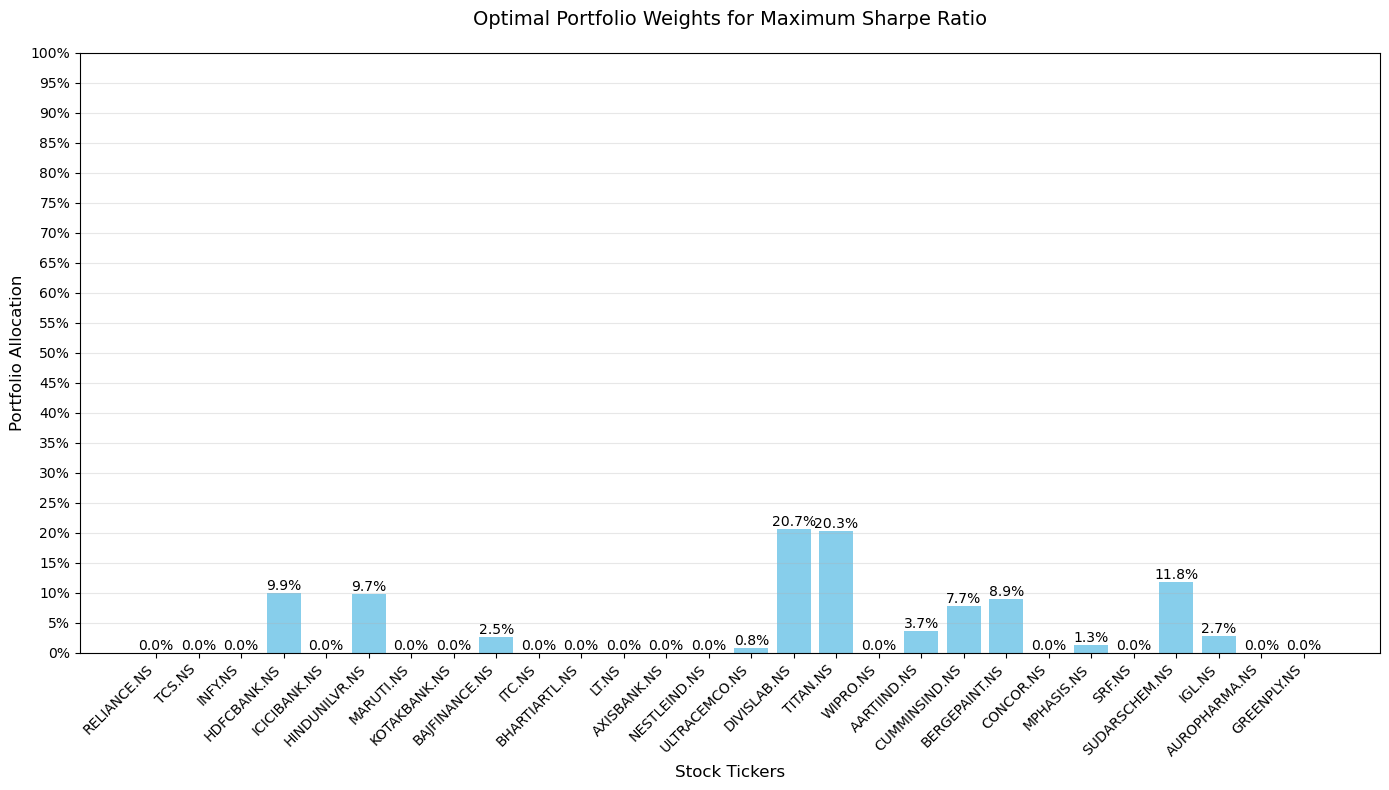

In [72]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 8))

# Create the bar plot with rotated x-axis labels
bars = plt.bar(tickers, optimal_weights, color='skyblue')

# Add value labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.1%}',
             ha='center', va='bottom')

# Formatting
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks([i/20 for i in range(0, 21)], [f'{i}%' for i in range(0, 105, 5)])
plt.xlabel('Stock Tickers', fontsize=12)
plt.ylabel('Portfolio Allocation', fontsize=12)
plt.title('Optimal Portfolio Weights for Maximum Sharpe Ratio', fontsize=14, pad=20)
plt.grid(axis='y', alpha=0.3)

# Adjust layout to prevent label cutoff
plt.tight_layout()

plt.show()